In [1]:
import h5py
import jax
import jax.numpy as jnp
import numpy as np
import healpy as hp
from functools import partial

In [7]:
import tensorflow_datasets as tfds
from tf_dataset_nbody import NbodyCosmogridDataset

# This makes TFDS aware of your dataset
tfds.builder.builder_from_directory("NbodyCosmogridDataset")

AttributeError: 'function' object has no attribute 'builder_from_directory'

# check gaussian construtction and projection

In [2]:
filename = '/home/tersenov/CosmoGridV1/CosmoGridV1_metainfo.h5'
f = h5py.File(filename, "r")
dataset_grid = f['parameters']['grid']

In [3]:
nside = 512
mean_pixel_area = 4 * np.pi / hp.nside2npix(nside)
scaling_factor = 1 / mean_pixel_area
xsize = 80  # width of figure in pixels
size = 10 # Size of square in degrees
reso = size * 60 / xsize
master_key = jax.random.PRNGKey(0)

In [4]:
cosmo_parameters = jnp.array([
            dataset_grid['Om'],
            dataset_grid['s8'],
            dataset_grid['w0'],
            dataset_grid['H0'],
            dataset_grid['ns'],
            dataset_grid['Ob']
        ]).T

nb_of_projected_map = 1
master_key = jax.random.PRNGKey(6)
key, master_key = jax.random.split(master_key)
params = cosmo_parameters[0]
path_string = '/home/tersenov/' + dataset_grid['path_par'][0].decode('utf-8').replace('CosmoGrid', 'CosmoGridV1').replace('raw', 'stage3_forecast')
for j in range(1): 
    filename = path_string + 'perm_000' + str(j) 
    filename_baryon = filename + '/projected_probes_maps_baryonified512.h5'
    filename_withouth_baryon = filename + '/projected_probes_maps_nobaryons512.h5'
    sim_with_baryon = h5py.File(filename_baryon, "r")
    sim_without_baryon = h5py.File(filename_withouth_baryon, "r")


    # keeping only last tomo bins
    nbody_map_without_baryon = np.array(sim_without_baryon['kg']['stage3_lensing{}'.format(4)])
    nbody_map_with_baryon_and_ia =  np.array(sim_with_baryon['kg']['stage3_lensing{}'.format(4)]) + np.array(sim_with_baryon['ia']['stage3_lensing{}'.format(4)])

    # building gaussian map
    lmax = 3*nside - 1  
    power_spectrum_nbody_map = hp.sphtfunc.anafast(nbody_map_without_baryon, lmax = lmax)
    z = np.random.randn(hp.nside2npix(nside)) * np.sqrt(scaling_factor) 
    power_spectrum_noise =  hp.sphtfunc.anafast(z, lmax = lmax)
    power_spectrum_target = power_spectrum_nbody_map / power_spectrum_noise
    alm_hp = hp.map2alm(z, lmax = lmax)
    alm = hp.sphtfunc.almxfl(alm_hp, np.sqrt(power_spectrum_target))
    gaussian_map = hp.alm2map(alm, nside, lmax = lmax)

    # projection
    key1, key2 = jax.random.split(key)
    lon = jax.random.randint(key1,(nb_of_projected_map,),-180, 180)
    lat = jax.random.randint(key2, (nb_of_projected_map,), -90, 90)
    for k in range(nb_of_projected_map):
        proj = hp.projector.GnomonicProj(rot=[lon[k], lat[k], 0], xsize=xsize, ysize=xsize, reso=reso)
        projection_nbody_w_baryon_ia = proj.projmap(nbody_map_with_baryon_and_ia, vec2pix_func=partial(hp.vec2pix, nside))
        projection_nbody = proj.projmap(nbody_map_without_baryon, vec2pix_func=partial(hp.vec2pix, nside))
        projection_gaussian = proj.projmap(gaussian_map, vec2pix_func=partial(hp.vec2pix, nside))

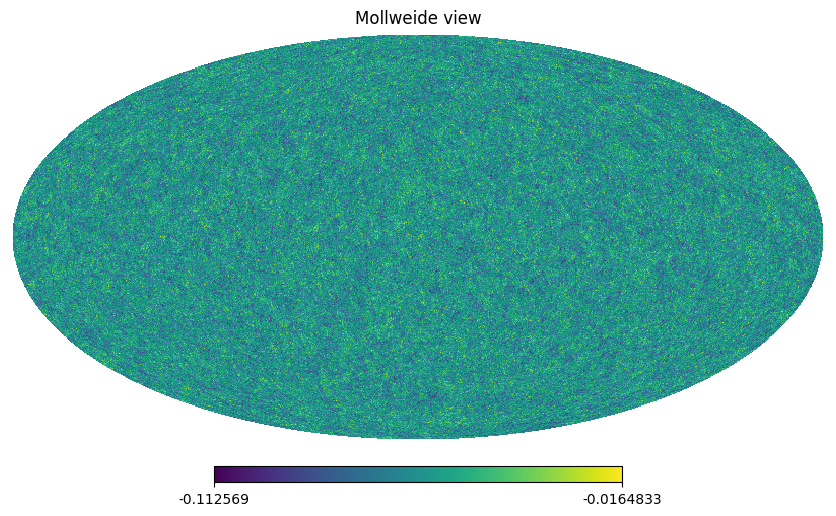

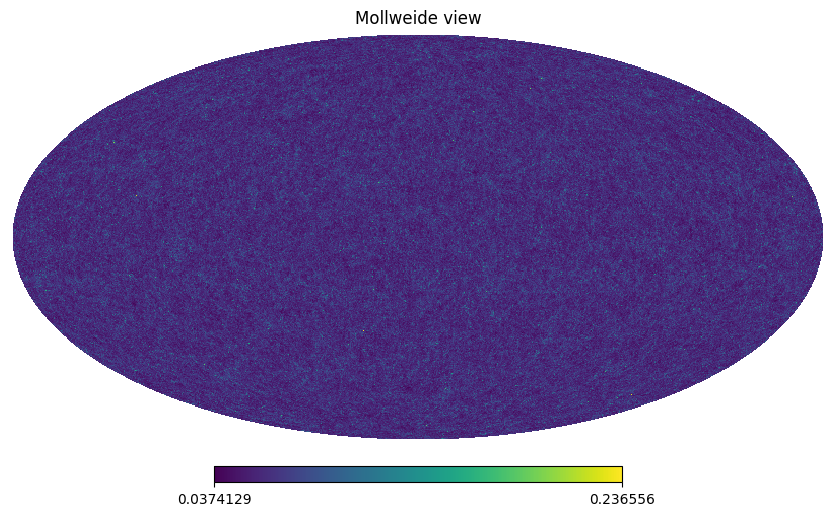

In [5]:
hp.mollview(gaussian_map)
hp.mollview(nbody_map_without_baryon)

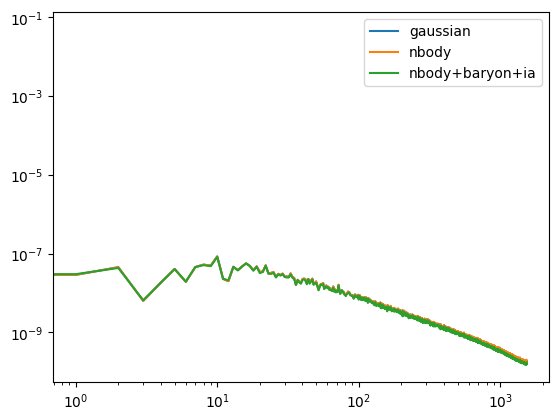

In [6]:
import matplotlib.pyplot as plt 
i = 0
power_spectrum_gaussian_map = hp.sphtfunc.anafast(gaussian_map, lmax = lmax)
power_spectrum_nbody_w_baryon_ia_map = hp.sphtfunc.anafast(nbody_map_with_baryon_and_ia, lmax = lmax)
power_spectrum_nbody_map = hp.sphtfunc.anafast(nbody_map_without_baryon, lmax = lmax)
plt.loglog(power_spectrum_gaussian_map[i:], label = 'gaussian')
plt.loglog(power_spectrum_nbody_map[i:], label = 'nbody')
plt.loglog(power_spectrum_nbody_w_baryon_ia_map[i:], label = 'nbody+baryon+ia')
plt.legend()

In [7]:
import astropy.units as u
from lenstools import ConvergenceMap
import numpy as np

l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
map_size=10

ell = ConvergenceMap(projection_gaussian, angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[0]
ps = ConvergenceMap(projection_gaussian, angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[1]

ell2 = ConvergenceMap(projection_nbody, angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[0]
ps2 = ConvergenceMap(projection_nbody, angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[1]

ell3 = ConvergenceMap(projection_nbody_w_baryon_ia, angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[0]
ps3 = ConvergenceMap(projection_nbody_w_baryon_ia, angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[1]

/home/tersenov/software/Learn2Map/learn2map/lib/python3.11/site-packages/lenstools/utils/mpi.py:15: UserWarning: Could not import mpi4py! (if you set sys.modules['mpi4py']=None please disregard this message)
  warnings.warn(wmsg)


AttributeError: module 'numpy' has no attribute 'complex'.
`np.complex` was a deprecated alias for the builtin `complex`. To avoid this error in existing code, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [8]:
plt.loglog(ell,ps, label ='gaussian')
plt.loglog(ell2, ps2, label ='nbody')
plt.loglog(ell3, ps3, label ='nbody+baryon+ia')
plt.legend()

NameError: name 'ell' is not defined

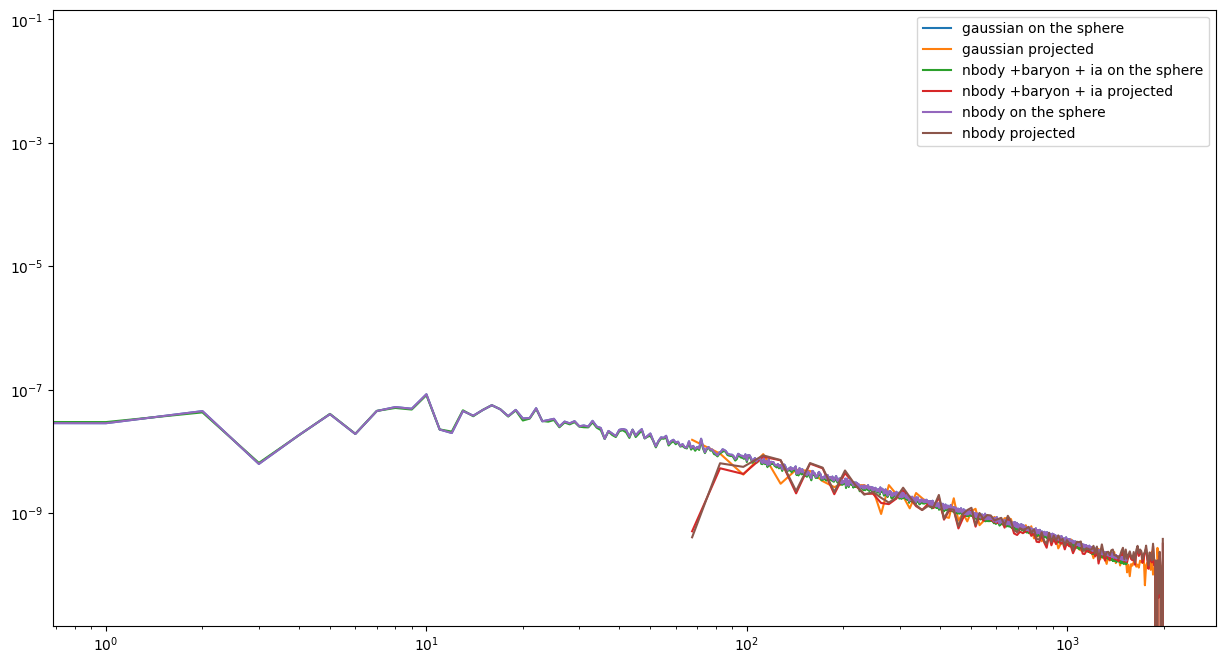

In [183]:
import matplotlib.pyplot as plt 
i = 0
plt.figure(figsize=(15,8))
power_spectrum_gaussian_map = hp.sphtfunc.anafast(gaussian_map, lmax = lmax)
plt.loglog(power_spectrum_gaussian_map[i:], label = 'gaussian on the sphere')
plt.loglog(ell, ps[i:], label = 'gaussian projected')
power_spectrum_nbody_w_baryon_ia_map = hp.sphtfunc.anafast(nbody_map_with_baryon_and_ia, lmax = lmax)
plt.loglog(power_spectrum_nbody_w_baryon_ia_map[i:], label = 'nbody +baryon + ia on the sphere')
plt.loglog(ell, ps3[i:], label = 'nbody +baryon + ia projected')
plt.loglog(power_spectrum_nbody_map[i:], label = 'nbody on the sphere')
plt.loglog(ell, ps2[i:], label = 'nbody projected')
plt.legend()

# to see where the projection is 

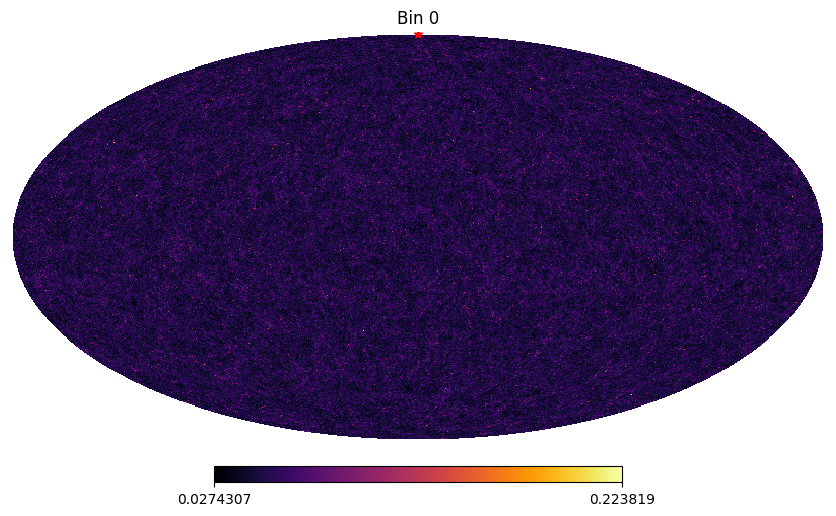

In [9]:
nside = 512
lon = 180
lat = 90

# Convert the flat array to a Healpix map
healpix_map = hp.pixelfunc.ud_grade(nbody_map_with_baryon_and_ia, nside_out=nside)

# Plotting the Healpix map on a sphere
hp.mollview(healpix_map, title='Bin {}'.format(i),cmap='inferno', nest=False)

# # Display the plot
hp.projscatter(lon, lat, lonlat=True, marker='*', color='red', label='Patch Location')
# hp.graticule()

# checking redshift distribution 

In [10]:
import numpy as np

for i in range(1,5):
    with open(f'./vae/nz/nz_stage3_{i}.txt', 'r') as file:
        lines = file.readlines()

    # Parse the text data into a list of lists (assuming numeric data separated by spaces or commas)
    data = []
    for line in lines:
        line_data = line.strip().split()  # Assuming space-separated data
        # If the data is comma-separated, use the following line instead:
        # line_data = line.strip().split(',')
        data.append([float(x) for x in line_data])  # Convert strings to floats

    # Convert the list of lists into a NumPy array
    nz = np.array(data)
    plt.plot(nz[:,0], nz[:,1])

FileNotFoundError: [Errno 2] No such file or directory: './vae/nz/nz_stage3_1.txt'

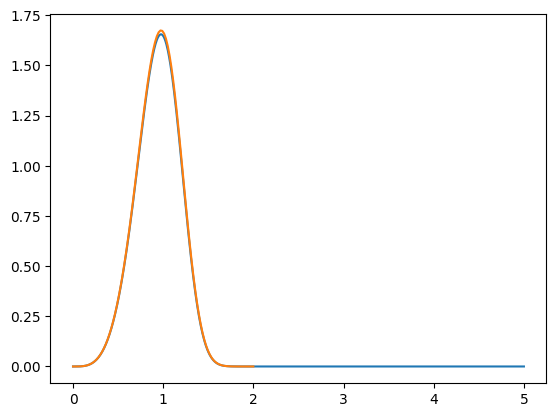

In [44]:
# lets try to match the distribution of bins 4 
pz4 = jc.redshift.smail_nz(3.53, 4.49, 1.03,gals_per_arcmin2=10/4, zmax=2.)
z = jnp.linspace(0,2,100)

plt.plot(nz[:,0],nz[:,1])
plt.plot(z,pz4.pz_fn(z)*4.)

In [11]:
# oook so 
from jax_cosmo.redshift import redshift_distribution
# @register_pytree_node_class
class smail_nz(redshift_distribution):
    """Defines a smail distribution with these arguments
    Parameters:
    -----------
    a:

    b:

    z0:

    gals_per_arcmin2: number of galaxies per sq arcmin
    """

    def pz_fn(self, z):
        a, b, z0 = self.params
        return z**a * np.exp(-((z / z0) ** b))*4

# checking dataset and noise augmentation 

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import jax.numpy as jnp

sigma_e = 0.26
galaxy_density = 10 / 4
field_size = size = 10
field_npix = xsize = 80
nside = 512
reso = size * 60 / xsize
nbins = 1
dim = 6

def augmentation_noise(
        example, sigma_e=0.26, galaxy_density=27, field_size=5, field_npix=256
    ):
        x = example["map_gaussian"]
        x += tf.random.normal(
            shape=(field_npix, field_npix),
            stddev=sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
        )

        return {"maps": x, "theta": example["theta"]}
    

def augmentation_flip(example):
    x = tf.expand_dims(example["maps"], -1)
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return {"maps": x, "theta": example["theta"]}

def rescale_h(example): 
    x = example['theta']
    index_to_update = 3
    x = tf.tensor_scatter_nd_update(x, [[index_to_update]], [x[index_to_update] / 100])
    return {"maps": example["maps"], "theta": x}

def augmentation(example):
    return rescale_h(
        augmentation_flip(
            augmentation_noise(
                example=example,
                sigma_e=sigma_e,
                galaxy_density=galaxy_density,
                field_size=field_size,
                field_npix=field_npix,
            )
        )
    )


ds_tr = tfds.load("CosmogridGridDataset/grid", split="train")

ds_tr = ds_tr.repeat()
ds_tr = ds_tr.shuffle(800)
# ds_tr = ds_tr.map(augmentation)
ds_tr = ds_tr.batch(5)
ds_tr = ds_tr.prefetch(tf.data.experimental.AUTOTUNE)
ds_train = iter(tfds.as_numpy(ds_tr))

2025-02-25 12:28:38.157906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740479318.168819  624939 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740479318.172189  624939 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


DatasetNotFoundError: Dataset cosmogrid_grid_dataset not found.
Available datasets:
	- abstract_reasoning
	- accentdb
	- aeslc
	- aflw2k3d
	- ag_news_subset
	- ai2_arc
	- ai2_arc_with_ir
	- ai2dcaption
	- aloha_mobile
	- amazon_us_reviews
	- anli
	- answer_equivalence
	- arc
	- asqa
	- asset
	- assin2
	- asu_table_top_converted_externally_to_rlds
	- austin_buds_dataset_converted_externally_to_rlds
	- austin_sailor_dataset_converted_externally_to_rlds
	- austin_sirius_dataset_converted_externally_to_rlds
	- bair_robot_pushing_small
	- bc_z
	- bccd
	- beans
	- bee_dataset
	- beir
	- berkeley_autolab_ur5
	- berkeley_cable_routing
	- berkeley_fanuc_manipulation
	- berkeley_gnm_cory_hall
	- berkeley_gnm_recon
	- berkeley_gnm_sac_son
	- berkeley_mvp_converted_externally_to_rlds
	- berkeley_rpt_converted_externally_to_rlds
	- big_patent
	- bigearthnet
	- billsum
	- binarized_mnist
	- binary_alpha_digits
	- ble_wind_field
	- blimp
	- booksum
	- bool_q
	- bot_adversarial_dialogue
	- bridge
	- bridge_data_msr
	- bucc
	- c4
	- c4_wsrs
	- caltech101
	- caltech_birds2010
	- caltech_birds2011
	- cardiotox
	- cars196
	- cassava
	- cats_vs_dogs
	- celeb_a
	- celeb_a_hq
	- cfq
	- cherry_blossoms
	- chexpert
	- cifar10
	- cifar100
	- cifar100_n
	- cifar10_1
	- cifar10_corrupted
	- cifar10_h
	- cifar10_n
	- citrus_leaves
	- cityscapes
	- civil_comments
	- clevr
	- clic
	- clinc_oos
	- cmaterdb
	- cmu_franka_exploration_dataset_converted_externally_to_rlds
	- cmu_play_fusion
	- cmu_stretch
	- cnn_dailymail
	- coco
	- coco_captions
	- coil100
	- colorectal_histology
	- colorectal_histology_large
	- columbia_cairlab_pusht_real
	- common_voice
	- conll2002
	- conll2003
	- conq_hose_manipulation
	- controlled_noisy_web_labels
	- coqa
	- corr2cause
	- cos_e
	- cosmos_qa
	- covid19
	- covid19sum
	- crema_d
	- criteo
	- cs_restaurants
	- curated_breast_imaging_ddsm
	- cycle_gan
	- d4rl_adroit_door
	- d4rl_adroit_hammer
	- d4rl_adroit_pen
	- d4rl_adroit_relocate
	- d4rl_antmaze
	- d4rl_mujoco_ant
	- d4rl_mujoco_halfcheetah
	- d4rl_mujoco_hopper
	- d4rl_mujoco_walker2d
	- dart
	- databricks_dolly
	- davis
	- deep1b
	- deep_weeds
	- definite_pronoun_resolution
	- dementiabank
	- diabetic_retinopathy_detection
	- diamonds
	- dices
	- div2k
	- dlr_edan_shared_control_converted_externally_to_rlds
	- dlr_sara_grid_clamp_converted_externally_to_rlds
	- dlr_sara_pour_converted_externally_to_rlds
	- dmlab
	- dobbe
	- doc_nli
	- dolma
	- dolphin_number_word
	- domainnet
	- downsampled_imagenet
	- drop
	- dsprites
	- dtd
	- duke_ultrasound
	- e2e_cleaned
	- efron_morris75
	- emnist
	- eraser_multi_rc
	- esnli
	- eth_agent_affordances
	- eurosat
	- fashion_mnist
	- flic
	- flores
	- fmb
	- food101
	- forest_fires
	- fractal20220817_data
	- fuss
	- gap
	- geirhos_conflict_stimuli
	- gem
	- genomics_ood
	- german_credit_numeric
	- gigaword
	- glove100_angular
	- glue
	- goemotions
	- gov_report
	- gpt3
	- gref
	- groove
	- grounded_scan
	- gsm8k
	- gtzan
	- gtzan_music_speech
	- hellaswag
	- higgs
	- hillstrom
	- horses_or_humans
	- howell
	- i_naturalist2017
	- i_naturalist2018
	- i_naturalist2021
	- iamlab_cmu_pickup_insert_converted_externally_to_rlds
	- imagenet2012
	- imagenet2012_corrupted
	- imagenet2012_fewshot
	- imagenet2012_multilabel
	- imagenet2012_real
	- imagenet2012_subset
	- imagenet_a
	- imagenet_lt
	- imagenet_pi
	- imagenet_r
	- imagenet_resized
	- imagenet_sketch
	- imagenet_v2
	- imagenette
	- imagewang
	- imdb_reviews
	- imperialcollege_sawyer_wrist_cam
	- io_ai_tech
	- irc_disentanglement
	- iris
	- istella
	- jaco_play
	- kaist_nonprehensile_converted_externally_to_rlds
	- kddcup99
	- kitti
	- kmnist
	- kuka
	- laion400m
	- lambada
	- lfw
	- librispeech
	- librispeech_lm
	- libritts
	- ljspeech
	- lm1b
	- locomotion
	- lost_and_found
	- lsun
	- lvis
	- malaria
	- maniskill_dataset_converted_externally_to_rlds
	- math_dataset
	- math_qa
	- mctaco
	- media_sum
	- mimic_play
	- mlqa
	- mnist
	- mnist_corrupted
	- movie_lens
	- movie_rationales
	- movielens
	- moving_mnist
	- mrqa
	- mslr_web
	- mt_opt
	- mtnt
	- multi_news
	- multi_nli
	- multi_nli_mismatch
	- natural_instructions
	- natural_questions
	- natural_questions_open
	- newsroom
	- nsynth
	- nyu_depth_v2
	- nyu_door_opening_surprising_effectiveness
	- nyu_franka_play_dataset_converted_externally_to_rlds
	- nyu_rot_dataset_converted_externally_to_rlds
	- ogbg_molpcba
	- omniglot
	- open_images_challenge2019_detection
	- open_images_v4
	- openbookqa
	- opinion_abstracts
	- opinosis
	- opus
	- oxford_flowers102
	- oxford_iiit_pet
	- para_crawl
	- pass
	- patch_camelyon
	- paws_wiki
	- paws_x_wiki
	- penguins
	- pet_finder
	- pg19
	- piqa
	- places365_small
	- placesfull
	- plant_leaves
	- plant_village
	- plantae_k
	- plex_robosuite
	- pneumonia_mnist
	- protein_net
	- q_re_cc
	- qa4mre
	- qasc
	- qm9
	- quac
	- quality
	- quickdraw_bitmap
	- race
	- radon
	- real_toxicity_prompts
	- reddit
	- reddit_disentanglement
	- reddit_tifu
	- ref_coco
	- resisc45
	- rlu_atari
	- rlu_atari_checkpoints
	- rlu_atari_checkpoints_ordered
	- rlu_control_suite
	- rlu_dmlab_explore_object_rewards_few
	- rlu_dmlab_explore_object_rewards_many
	- rlu_dmlab_rooms_select_nonmatching_object
	- rlu_dmlab_rooms_watermaze
	- rlu_dmlab_seekavoid_arena01
	- rlu_locomotion
	- rlu_rwrl
	- robo_set
	- robomimic_mg
	- robomimic_mh
	- robomimic_ph
	- robonet
	- robosuite_panda_pick_place_can
	- roboturk
	- rock_paper_scissors
	- rock_you
	- s3o4d
	- salient_span_wikipedia
	- samsum
	- savee
	- scan
	- scene_parse150
	- schema_guided_dialogue
	- sci_tail
	- scicite
	- scientific_papers
	- scrolls
	- segment_anything
	- sentiment140
	- shapes3d
	- sift1m
	- simpte
	- siscore
	- smallnorb
	- smart_buildings
	- smartwatch_gestures
	- snli
	- so2sat
	- speech_commands
	- spoc_robot
	- spoken_digit
	- squad
	- squad_question_generation
	- stanford_dogs
	- stanford_hydra_dataset_converted_externally_to_rlds
	- stanford_kuka_multimodal_dataset_converted_externally_to_rlds
	- stanford_mask_vit_converted_externally_to_rlds
	- stanford_online_products
	- stanford_robocook_converted_externally_to_rlds
	- star_cfq
	- starcraft_video
	- stl10
	- story_cloze
	- summscreen
	- sun397
	- super_glue
	- svhn_cropped
	- symmetric_solids
	- taco_play
	- tao
	- tatoeba
	- ted_hrlr_translate
	- ted_multi_translate
	- tedlium
	- tf_flowers
	- the300w_lp
	- tidybot
	- tiny_shakespeare
	- titanic
	- tokyo_u_lsmo_converted_externally_to_rlds
	- toto
	- trec
	- trivia_qa
	- tydi_qa
	- uc_merced
	- ucf101
	- ucsd_kitchen_dataset_converted_externally_to_rlds
	- ucsd_pick_and_place_dataset_converted_externally_to_rlds
	- uiuc_d3field
	- unified_qa
	- universal_dependencies
	- unnatural_instructions
	- usc_cloth_sim_converted_externally_to_rlds
	- user_libri_audio
	- user_libri_text
	- utaustin_mutex
	- utokyo_pr2_opening_fridge_converted_externally_to_rlds
	- utokyo_pr2_tabletop_manipulation_converted_externally_to_rlds
	- utokyo_saytap_converted_externally_to_rlds
	- utokyo_xarm_bimanual_converted_externally_to_rlds
	- utokyo_xarm_pick_and_place_converted_externally_to_rlds
	- vctk
	- vima_converted_externally_to_rlds
	- viola
	- visual_domain_decathlon
	- voc
	- voxceleb
	- voxforge
	- wake_vision
	- waymo_open_dataset
	- web_graph
	- web_nlg
	- web_questions
	- webvid
	- wider_face
	- wiki40b
	- wiki_auto
	- wiki_bio
	- wiki_dialog
	- wiki_table_questions
	- wiki_table_text
	- wikiann
	- wikihow
	- wikipedia
	- wikipedia_toxicity_subtypes
	- wine_quality
	- winogrande
	- wit
	- wit_kaggle
	- wmt13_translate
	- wmt14_translate
	- wmt15_translate
	- wmt16_translate
	- wmt17_translate
	- wmt18_translate
	- wmt19_translate
	- wmt_t2t_translate
	- wmt_translate
	- wordnet
	- wsc273
	- xnli
	- xquad
	- xsum
	- xtreme_pawsx
	- xtreme_pos
	- xtreme_s
	- xtreme_xnli
	- yahoo_ltrc
	- yelp_polarity_reviews
	- yes_no
	- youtube_vis

Check that:
    - if dataset was added recently, it may only be available
      in `tfds-nightly`
    - the dataset name is spelled correctly
    - dataset class defines all base class abstract methods
    - the module defining the dataset class is imported

The builder directory /home/tersenov/tensorflow_datasets/cosmogrid_grid_dataset/grid doesn't contain any versions.
No builder could be found in the directory: /home/tersenov/tensorflow_datasets for the builder: cosmogrid_grid_dataset.
No registered data_dirs were found in:
	- /home/tersenov/tensorflow_datasets


: 

In [2]:
test = next(ds_train)

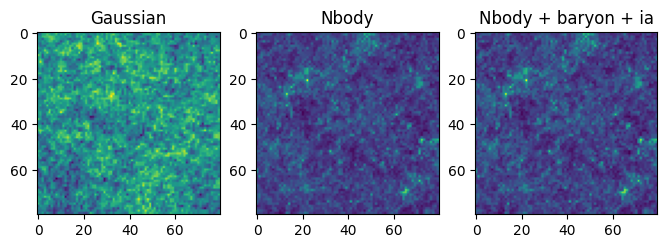

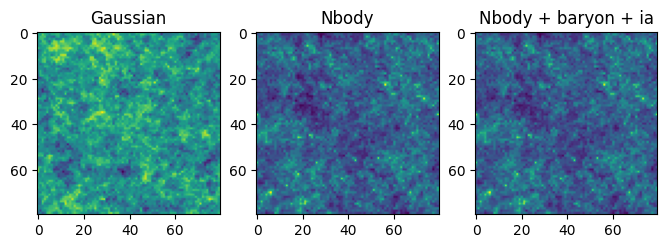

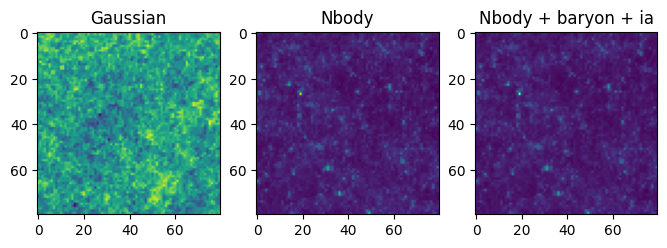

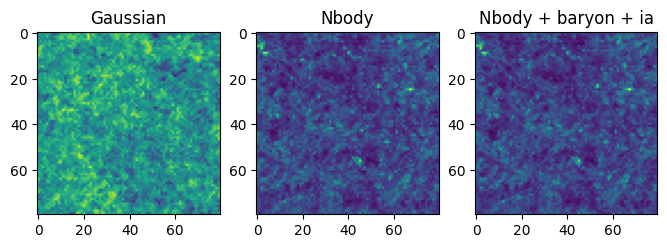

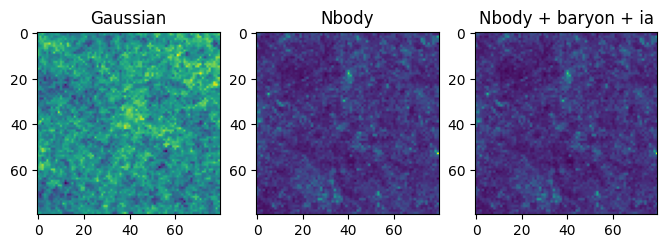

In [3]:
import matplotlib.pyplot as plt

for i in range(5): 
    plt.figure(figsize = (8,4))
    plt.subplot(1,3,1)
    plt.imshow(test['map_gaussian'][i]);plt.title('Gaussian')
    plt.subplot(1,3,2)
    plt.imshow(test['map_nbody'][i]);plt.title('Nbody')
    plt.subplot(1,3,3)
    plt.imshow(test['map_nbody_w_baryon_ia'][i]);plt.title('Nbody + baryon + ia')
    plt.show()
    
    
# supposed to see the same structures in gaussian map?

In [60]:
def augmentation_noise(
        example, sigma_e=sigma_e, galaxy_density=galaxy_density, field_size=field_size, field_npix=field_npix
    ):
        x = example["map_gaussian"]
        x += tf.random.normal(
            shape=(field_npix, field_npix),
            stddev=sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
        )
        
        y = example["map_nbody"]
        y += tf.random.normal(
            shape=(field_npix, field_npix),
            stddev=sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
        )
        
        z = example['map_nbody_w_baryon_ia']
        z += tf.random.normal(
            shape=(field_npix, field_npix),
            stddev=sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
        )

        return {"map_gaussian": x, "map_nbody": y, 'map_nbody_w_baryon_ia':z, 'theta':example['theta']}
    
ds_tr = tfds.load("CosmogridGridDataset/grid", split="train")

ds_tr = ds_tr.repeat()
ds_tr = ds_tr.shuffle(800)
ds_tr = ds_tr.map(augmentation_noise)
ds_tr = ds_tr.batch(500)
ds_tr = ds_tr.prefetch(tf.data.experimental.AUTOTUNE)
ds_train = iter(tfds.as_numpy(ds_tr))

In [61]:
ex = next(ds_train)

In [62]:
import astropy.units as u
from lenstools import ConvergenceMap
import numpy as np

nb = 1 # because it is not at fixed cosmo

l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
map_size=10

ell = ConvergenceMap(ex['map_gaussian'][0], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[0]
ps = []
for i in range(nb):
    ps.append(ConvergenceMap(ex['map_gaussian'][i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[1])
ps = np.mean(ps, axis =0)

ell2 = ConvergenceMap(ex['map_nbody'][0], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[0]
ps2 = []
for i in range(nb):
    ps2.append(ConvergenceMap(ex['map_nbody'][i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[1])
ps2 = np.mean(ps2, axis =0)

ell3 = ConvergenceMap(ex['map_nbody_w_baryon_ia'][0], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[0]
ps3 = []
for i in range(nb):
    ps3.append(ConvergenceMap(ex['map_nbody_w_baryon_ia'][i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[1])
ps3 = np.mean(ps3, axis =0)

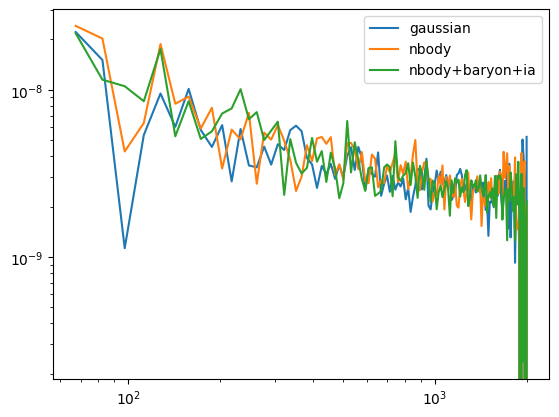

In [63]:
plt.loglog(ell,ps, label ='gaussian')
plt.loglog(ell2, ps2, label ='nbody')
plt.loglog(ell3, ps3, label ='nbody+baryon+ia')
plt.legend()

In [66]:
import jax_cosmo as jc
# filename = '/gpfsdswork/dataset/CosmoGridV1/CosmoGridV1_metainfo.h5'
# f = h5py.File(filename, "r")
# dataset_grid = f['parameters']['fiducial']

# power spectrum from theory
cosmo = jc.Planck15(
    Omega_c=ex['theta'][0][0] - ex['theta'][0][-1],
    Omega_b=ex['theta'][0][-1],
    h=ex['theta'][0][3] / 100,
    n_s=ex['theta'][0][4],
    sigma8=ex['theta'][0][1],
    Omega_k=0.0,
    w0=ex['theta'][0][2],
    wa=0.0,
)

nz_bins = jc.redshift.smail_nz(3.53, 4.49, 1.03, gals_per_arcmin2=10/4)
tracer = jc.probes.WeakLensing([nz_bins], sigma_e=sigma_e)

cell_theory = jc.angular_cl.angular_cl(cosmo, ell, [tracer])
cell_noise = jc.angular_cl.noise_cl(ell, [tracer])
Cl_theo = cell_theory + cell_noise

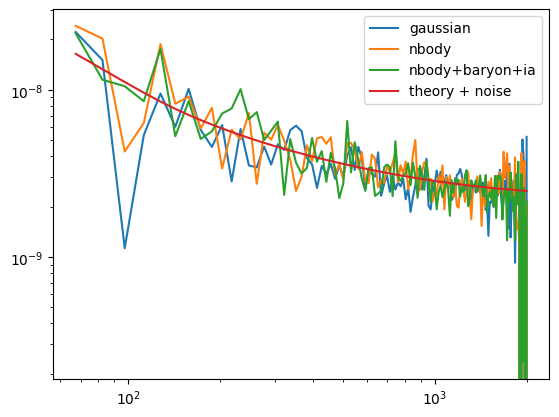

In [67]:
plt.loglog(ell,ps, label ='gaussian')
plt.loglog(ell2, ps2, label ='nbody')
plt.loglog(ell3, ps3, label ='nbody+baryon+ia')
plt.loglog(ell, Cl_theo[0], label ='theory + noise')
plt.legend()

In [72]:
def augmentation_noise(
        example, sigma_e=sigma_e, galaxy_density=galaxy_density, field_size=field_size, field_npix=field_npix
    ):

        
        y = example["map_nbody"]
        y += tf.random.normal(
            shape=(field_npix, field_npix),
            stddev=sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
        )
    

        return { "map_nbody": y, 'theta':example['theta']}
    
ds_tr = tfds.load("CosmogridGridFiducialDataset/fiducial", split="train")

ds_tr = ds_tr.repeat()
ds_tr = ds_tr.shuffle(800)
ds_tr = ds_tr.map(augmentation_noise)
ds_tr = ds_tr.batch(500)
ds_tr = ds_tr.prefetch(tf.data.experimental.AUTOTUNE)
ds_train = iter(tfds.as_numpy(ds_tr))

In [73]:
ex = next(ds_train)

In [83]:
import astropy.units as u
from lenstools import ConvergenceMap
import numpy as np

nb = 45 # because it is at fixed cosmo

l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
map_size=10

ell2 = ConvergenceMap(ex['map_nbody'][0], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[0]
ps2 = []
for i in range(nb):
    ps2.append(ConvergenceMap(ex['map_nbody'][i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[1])
ps2 = np.mean(ps2, axis =0)
std2 = np.std(ps2, axis =0)

In [84]:
cosmo = jc.Planck15(
    Omega_c=ex['theta'][0][0] - ex['theta'][0][-1],
    Omega_b=ex['theta'][0][-1],
    h=ex['theta'][0][3] / 100,
    n_s=ex['theta'][0][4],
    sigma8=ex['theta'][0][1],
    Omega_k=0.0,
    w0=ex['theta'][0][2],
    wa=0.0,
)

nz_bins = jc.redshift.smail_nz(3.53, 4.49, 1.03, gals_per_arcmin2=10/4)
tracer = jc.probes.WeakLensing([nz_bins], sigma_e=sigma_e)

cell_theory = jc.angular_cl.angular_cl(cosmo, ell, [tracer])
cell_noise = jc.angular_cl.noise_cl(ell, [tracer])
Cl_theo = cell_theory + cell_noise

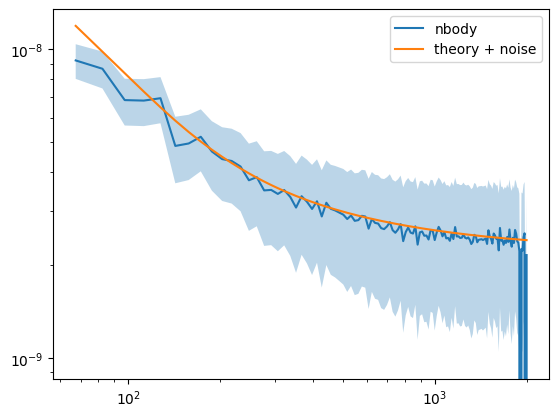

In [85]:
plt.loglog(ell2, ps2, label ='nbody')
plt.fill_between(ell2, ps2+1 *std2, ps2-1 *std2,  alpha=0.3)
plt.loglog(ell, Cl_theo[0], label ='theory + noise')
plt.legend()